In [1]:
import os
# network configurations
from configuration import Configuration
from net.mask_rcnn import MaskRcnnNet
# data loader, transforms and samplers
from torch.utils.data import DataLoader
from loader.dsb2018.dataset import ScienceDataset, multi_mask_to_annotation
from loader.transforms import *
from loader.sampler import *
# visualize utils
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# DataLoader

In [2]:
# init dataset and dataloader!
def test_augment(image, index):
    pad_image = pad_to_factor(image, factor=16)
    input = torch.from_numpy(pad_image.transpose((2, 0, 1))).float().div(255)
    return input, image, index

def test_collate(batch):
    batch_size = len(batch)
    inputs = torch.stack([batch[b][0] for b in range(batch_size)], 0)
    images = [batch[b][1] for b in range(batch_size)]
    indices = [batch[b][2] for b in range(batch_size)]
    return [inputs, images, indices]

In [3]:
cfg = Configuration()
test_dataset = ScienceDataset(cfg, 'valid', mode='test', transform=test_augment)
test_loader = DataLoader(
        test_dataset,
        sampler=SequentialSampler(test_dataset),
        batch_size=1,
        drop_last=False,
        num_workers=4,
        pin_memory=True,
        collate_fn=test_collate)

image index:  0 tensor size:  torch.Size([3, 368, 368])


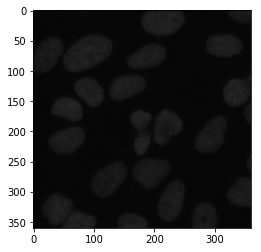

In [4]:
# get first batch of the data!
for i, (inputs, images, indices) in enumerate(test_loader, 0):
    if i == 0:  # pick one picture of the batch!
        tensor = inputs[0]
        image  = images[0]
        index = indices[0]
        break
print('image index: ', index, 'tensor size: ', tensor.size())
plt.imshow(image)

# NetWork

In [5]:
# init network from pretrained model!
net = MaskRcnnNet(cfg).to(cfg.device)
net.load_pretrain('00021000_model.pth')

In [6]:
# run prediction! it will take a few seconds if you use cpu
net.set_mode('test')
with torch.no_grad():
    net(inputs.to(cfg.device))

# Predict Multi Masks

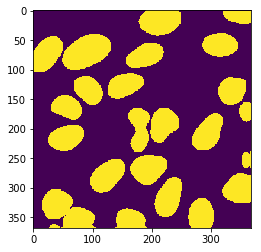

In [7]:
# get the first mask from the batch!
mask = net.masks[0]
plt.imshow(mask != 0)

# Regional Proposals

In [8]:
# what about boxes?
boxes = net.detections[:, 1:5].numpy()
# take a look of the boxes, they are [x0, y0, x1, y1]
boxes

array([[256., 162., 332., 247.],
       [276.,  28., 357.,  89.],
       [ 85., 239., 168., 319.],
       [145.,  43., 231., 109.],
       [ 15., 182.,  97., 249.],
       [131., 327., 201., 367.],
       [167.,   0., 262.,  55.],
       [252., 307., 315., 367.],
       [115.,  97., 198., 161.],
       [308., 265., 367., 337.],
       [193., 270., 262., 360.],
       [303., 100., 367., 172.],
       [312.,   1., 367.,  31.],
       [ 59., 100., 128., 171.],
       [ 19., 134.,  93., 193.],
       [152., 234., 238., 307.],
       [  4., 290.,  79., 362.],
       [347., 233., 367., 272.],
       [ 39., 322., 116., 367.],
       [ 33.,  28., 146., 114.],
       [341., 148., 367., 196.],
       [  0.,  32.,  62., 116.],
       [187., 154., 258., 237.],
       [ 24., 358.,  49., 367.],
       [154., 186., 204., 249.],
       [153., 155., 206., 228.]], dtype=float32)

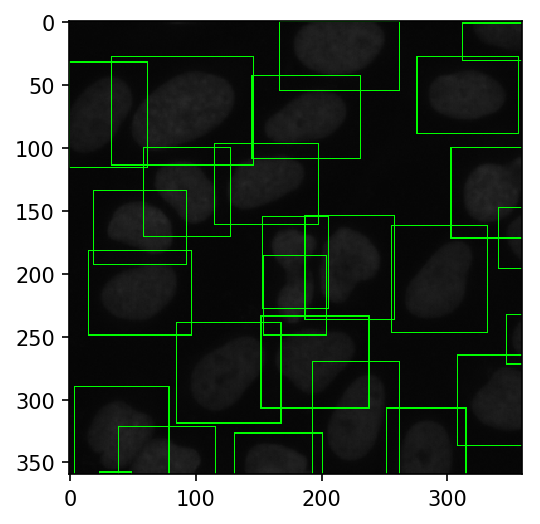

In [10]:
from net.utils.draw import draw_boxes
# Let's draw them out!
mpl.rcParams['figure.dpi'] = 150
draw_boxes(image, boxes, color=(0, 255, 0))
plt.imshow(image)

# Probability Map

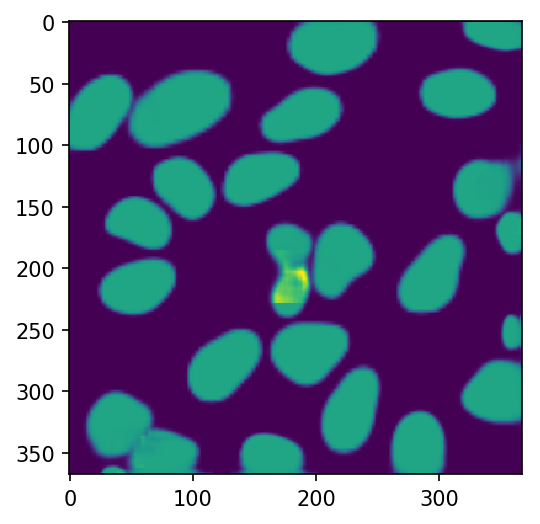

In [11]:
# what about the probability map?
# let's stack all the probability maps on one canvas and plot them
canvas = np.zeros(net.mask_instances[0][0].shape)
for instance in net.mask_instances[0]:
    canvas += instance
plt.imshow(canvas)